# Recherche de tendances et de saisonnalités

In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [2]:
apple_df = pd.read_csv("datas/apple_data.csv")
apple_df.head()

,date,open,high,low,close,volume
0,2010-01-04,7.62,7.66,7.58,7.64,493729600
1,2010-01-05,7.66,7.70,7.62,7.66,601904800
2,2010-01-06,7.66,7.69,7.53,7.53,552160000
3,2010-01-07,7.56,7.57,7.47,7.52,477131200
4,2010-01-08,7.51,7.57,7.47,7.57,447876740


In [3]:
apple_df['date'] = pd.to_datetime(apple_df['date'])

## Tendance
Moyenne mobile centrée sur un an : 252 jours ouvrés pour la bourse

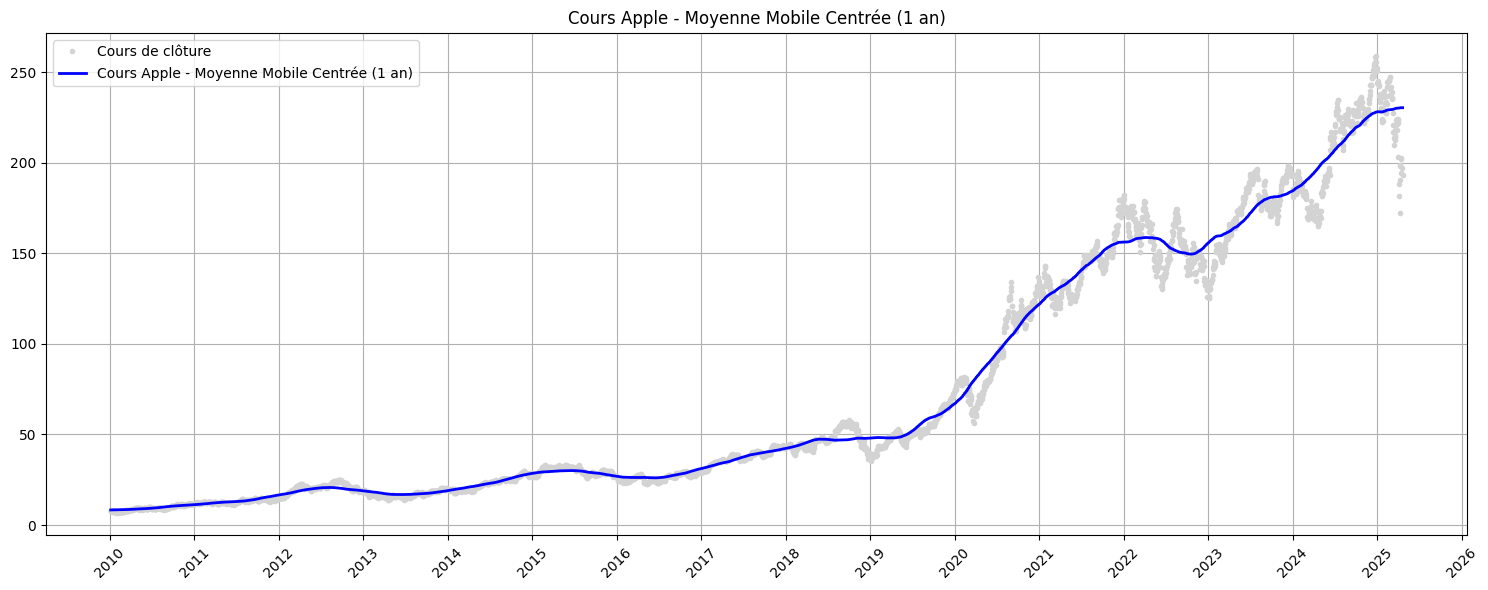

In [4]:
close_apple = apple_df['close']

apple_df['moving_average'] = close_apple.rolling(
    window=252,
    center=True,
    min_periods=126,
).mean()

fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(apple_df['date'], apple_df['close'], '.', color='lightgray', label='Cours de clôture')
ax.plot(apple_df['date'], apple_df['moving_average'], color='blue', linewidth=2, label="Cours Apple - Moyenne Mobile Centrée (1 an)")

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax.set_title("Cours Apple - Moyenne Mobile Centrée (1 an)")
ax.legend()
plt.grid(True)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

On observe une tendance à l'augmentation

## Saisonnalité

### Recherche de saisonnalité par mois

- Avec .mean

In [5]:
print(apple_df['date'])

0      2010-01-04
1      2010-01-05
2      2010-01-06
3      2010-01-07
4      2010-01-08
          ...    
3843   2025-04-14
3844   2025-04-15
3845   2025-04-16
3846   2025-04-17
3847   2025-04-21
Name: date, Length: 3848, dtype: datetime64[ns]


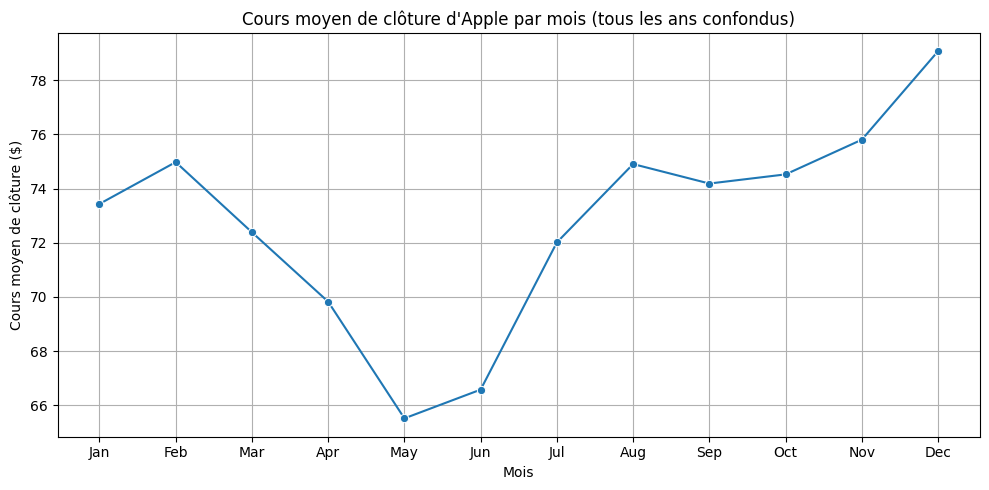

In [6]:
apple_df['month'] = apple_df['date'].dt.month
monthly_avg = apple_df.groupby('month')['close'].mean()

plt.figure(figsize=(10, 5))
sns.lineplot(x=monthly_avg.index, y=monthly_avg.values, marker='o')

plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title("Cours moyen de clôture d'Apple par mois (tous les ans confondus)")
plt.xlabel("Mois")
plt.ylabel("Cours moyen de clôture ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

- Avec .median

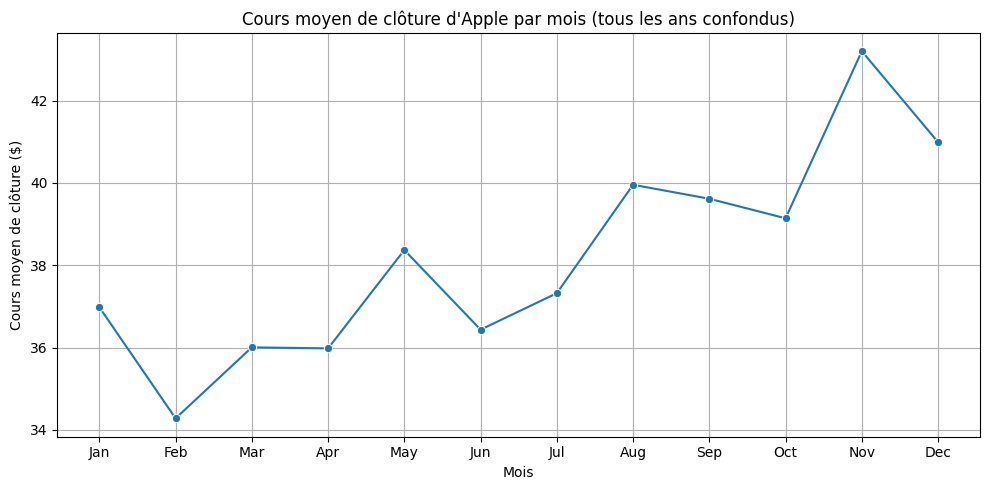

In [7]:
apple_df['month'] = apple_df['date'].dt.month
monthly_avg = apple_df.groupby('month')['close'].median()

plt.figure(figsize=(10, 5))
sns.lineplot(x=monthly_avg.index, y=monthly_avg.values, marker='o')

plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title("Cours moyen de clôture d'Apple par mois (tous les ans confondus)")
plt.xlabel("Mois")
plt.ylabel("Cours moyen de clôture ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Recherche de saisonnalité par mois + année

- Heatmap

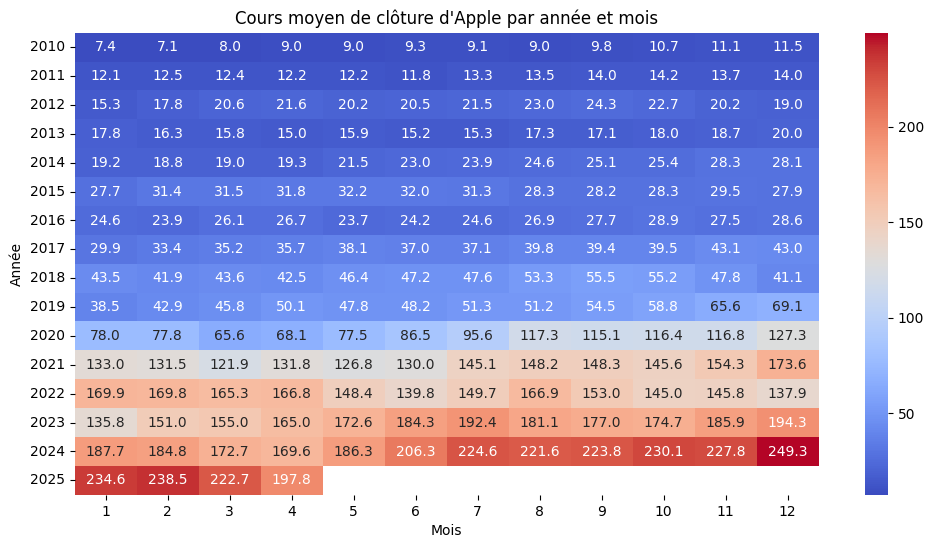

In [8]:
apple_df['year'] = apple_df['date'].dt.year

pivot_table = apple_df.pivot_table(
    values='close',
    index='year',
    columns='month',
    aggfunc='mean'
)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt=".1f")
plt.title("Cours moyen de clôture d'Apple par année et mois")
plt.xlabel("Mois")
plt.ylabel("Année")
plt.show()

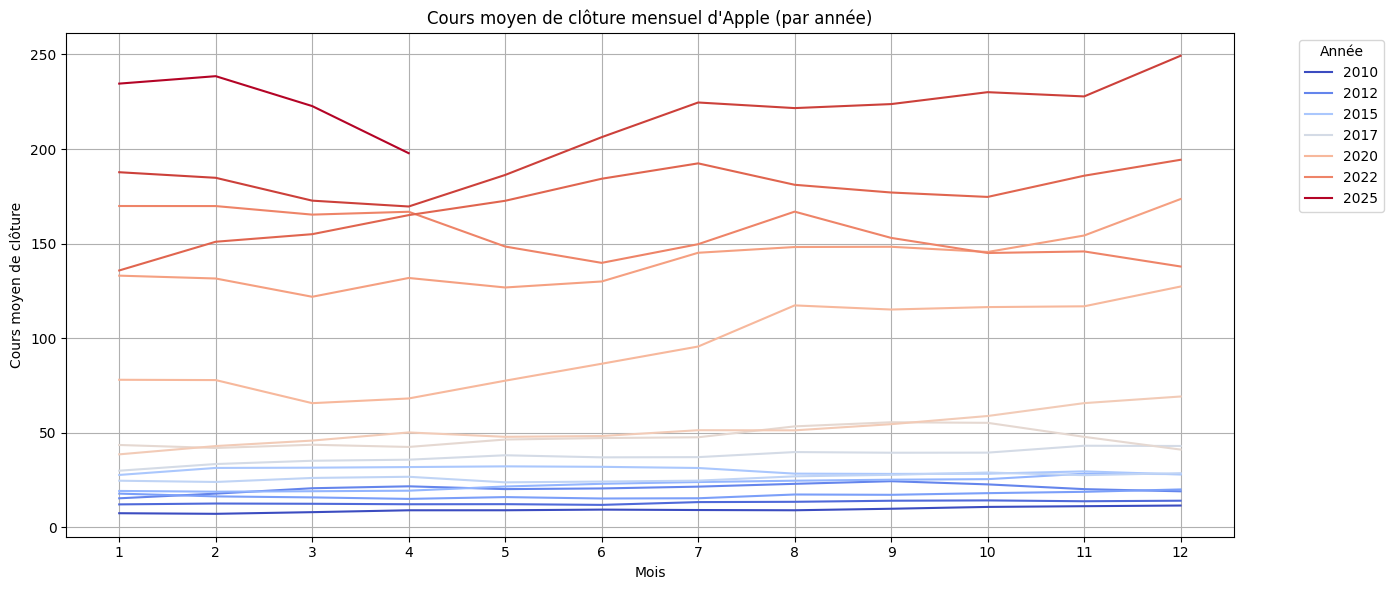

In [9]:
monthly_mean = apple_df.groupby(['year','month'])['close'].mean().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_mean, x='month', y='close', hue='year', palette='coolwarm')
plt.title("Cours moyen de clôture mensuel d'Apple (par année)")
plt.xlabel("Mois")
plt.ylabel("Cours moyen de clôture")
plt.xticks(range(1,13))
plt.grid(True)
plt.legend(title='Année', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Statmodels

- Additive

In [10]:
apple_df = apple_df.set_index('date')
apple_df = apple_df.sort_index()

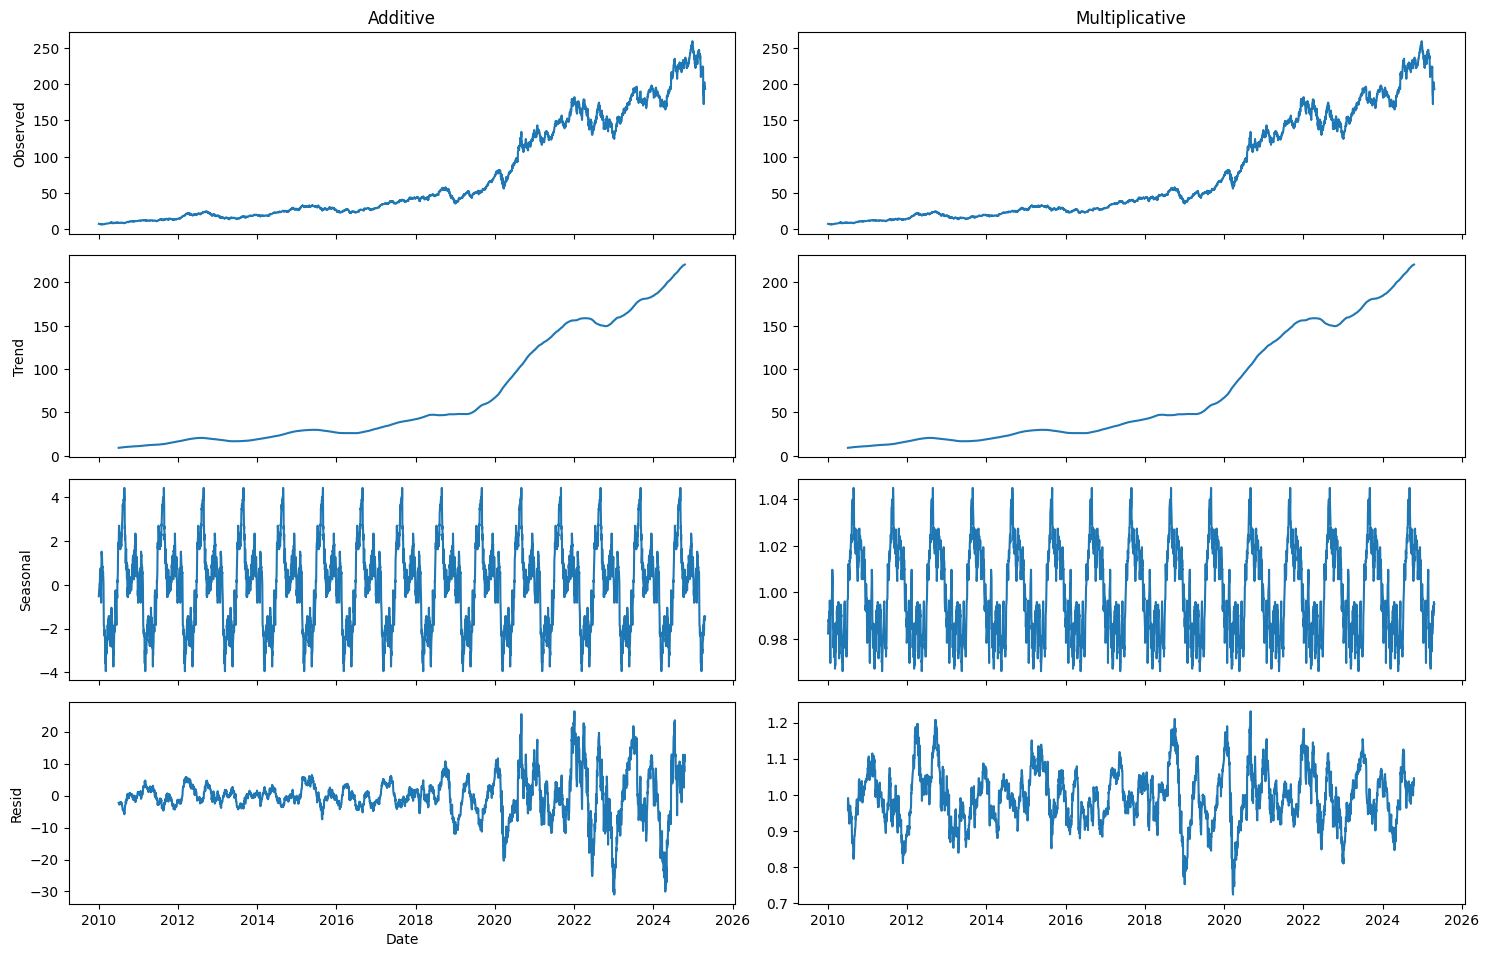

In [11]:
close_series = apple_df['close']
decomposition_add = seasonal_decompose(close_series, model='additive', period=252)
decomposition_mult = seasonal_decompose(close_series, model='multiplicative', period=252)

fig, axes = plt.subplots(4, 2, figsize=(15, 10), sharex=True)

axes[0, 0].plot(decomposition_add.observed)
axes[0, 0].set_ylabel("Observed")
axes[1, 0].plot(decomposition_add.trend)
axes[1, 0].set_ylabel("Trend")
axes[2, 0].plot(decomposition_add.seasonal)
axes[2, 0].set_ylabel("Seasonal")
axes[3, 0].plot(decomposition_add.resid)
axes[3, 0].set_ylabel("Resid")
axes[3, 0].set_xlabel("Date")
axes[0, 0].set_title("Additive")

# Graphiques pour la décomposition multiplicative
axes[0, 1].plot(decomposition_mult.observed)
axes[1, 1].plot(decomposition_mult.trend)
axes[2, 1].plot(decomposition_mult.seasonal)
axes[3, 1].plot(decomposition_mult.resid)
axes[0, 1].set_title("Multiplicative")

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

On constate une saisonnalité annuelle : que ce soit en additive ou en multiplicative, un pattern se répète 15 fois, c'est-à-dire chaque année

## Autocorrélation

Permet de repérer si les valeurs passées influencent les valeurs futures

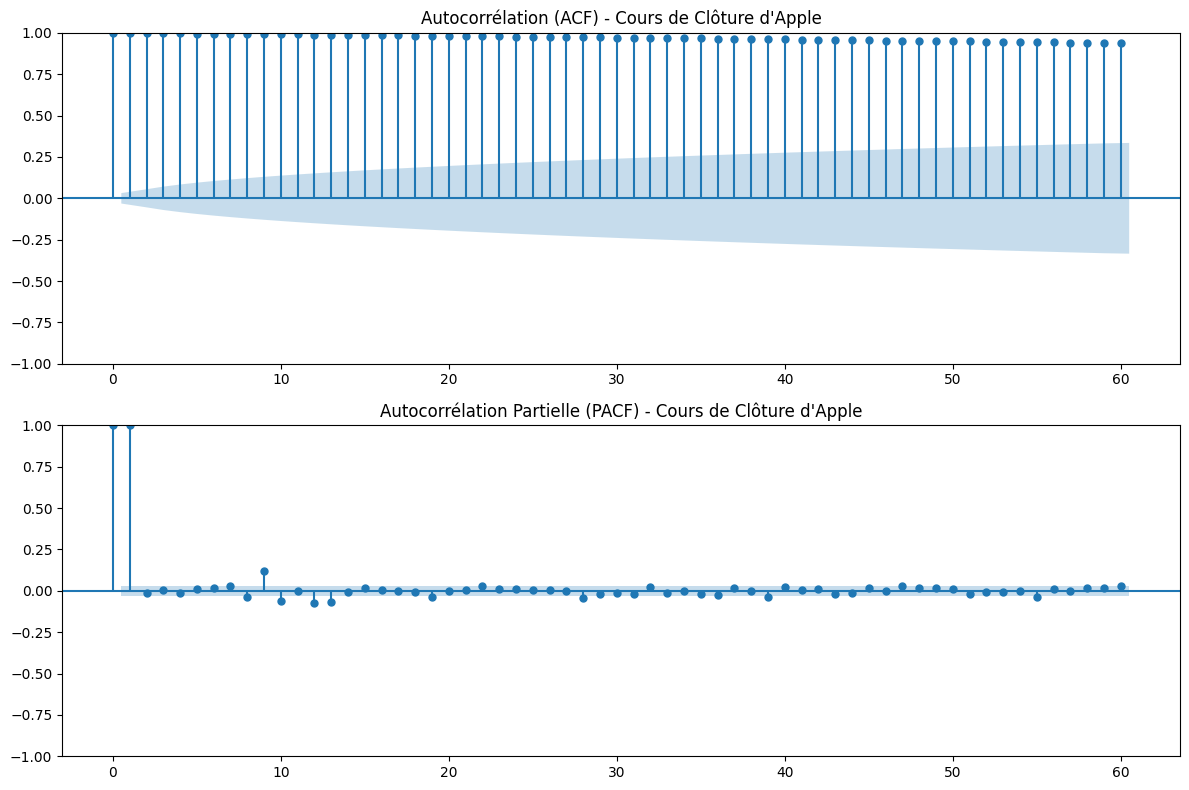

In [12]:
fig, ax = plt.subplots(2,1, figsize=(12, 8))

plot_acf(close_apple, ax=ax[0], lags=60)
ax[0].set_title("Autocorrélation (ACF) - Cours de Clôture d'Apple")

plot_pacf(close_apple, ax=ax[1], lags=60, method='ywm')
ax[1].set_title("Autocorrélation Partielle (PACF) - Cours de Clôture d'Apple")

plt.tight_layout()
plt.show()

- L'ACF diminue lentement : la série est non stationnaire (les propriétés de la série ne sont pa constantes et peuvent varier)
Présence d'une tendance non stationnaire -> les valeurs futures restent fortement corrélées aux valeurs passées

### Autocorrélation dans le temps

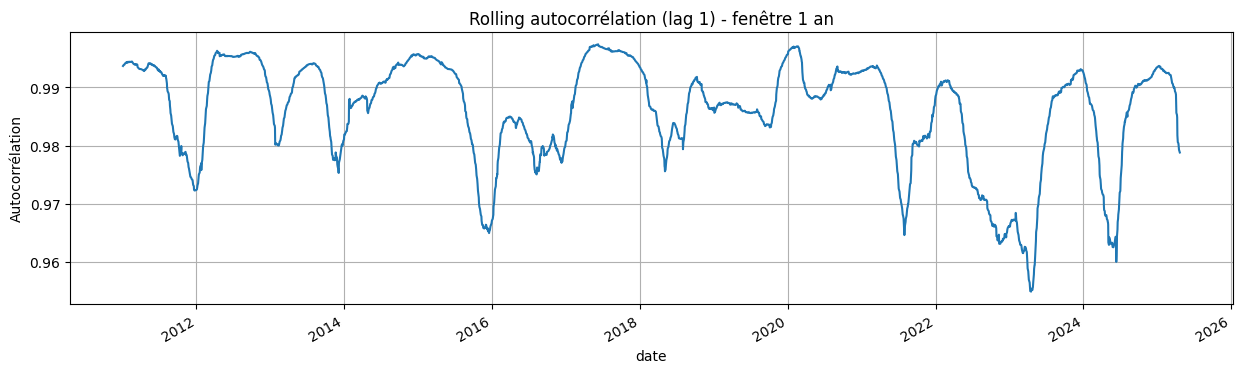

In [13]:
window = 252
rolling_corr = apple_df['close'].rolling(window).corr(apple_df['close'].shift(1))

plt.figure(figsize=(15, 4))
rolling_corr.plot()
plt.title("Rolling autocorrélation (lag 1) - fenêtre 1 an")
plt.ylabel("Autocorrélation")
plt.grid(True)
plt.show()

## Test statistiques ADF (Augmented Dickey-Fuller)

Pour déterminer statistiquement si la série est stationnaire ou pas

In [14]:
result = adfuller(close_apple)

print(f"Statistique de test ADF: {result[0]}")
print(f"P Value: {result[1]}")
for key, value in result[4].items():
    print(f"Critère {key}: {value}")

Statistique de test ADF: 0.008432564070183907
P Value: 0.959223922213221
Critère 1%: -3.432064357649079
Critère 5%: -2.8622975090375453
Critère 10%: -2.567173231836065


La p-value est trop élevée donc la série n'est pas stationnaire